In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset and Dataloader

In [2]:
from torchvision import datasets, transforms # Untuk handle data image
from torch.utils.data import DataLoader

In [8]:
BATCH_SIZE = 128

# Kita buat
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [56]:
feature, target = next(iter(trainloader))
feature.shape # Karena PyTorch, harus n,c,h,w (data, channel, height, width)

torch.Size([128, 1, 28, 28])

In [57]:
feature.shape[2] * feature.shape[3]

784

In [15]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur dan Config 

# Cara 1 Pakai library jcopdl 

In [16]:
from jcopdl.layers import linear_block

In [17]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(), # Karena image, di input shape nya di Flatten terlebih dahulu
            linear_block(input_size, n1, dropout=dropout), # Isi linear_block itu layer linear -> ReLU -> Dropout
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation='lsoftmax')
        )
        
        
    def forward(self, x):
        return self.fc(x)

# Cara 2  

In [ ]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(), # Karena image, di input shape nya di Flatten terlebih dahulu
            nn.Linear(input_size, n1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n2, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.fc(x)

In [21]:
config = set_config({
    "input_size": feature.shape[2] * feature.shape[3],
    "n1": 256,
    "n2": 128,
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

In [22]:
config.input_size

784

# Training Preparation -> MCOC (Model, Criterion, Optimizer, Callback) 

In [24]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training 

In [33]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    
    return cost, acc

Test: 100%|████████████████████████████████████████████| 157/157 [01:26<00:00,  1.82it/s]



Epoch     1
Train_cost  = 0.4216 | Test_cost  = 0.3725 | Train_score = 0.8489 | Test_score = 0.8631 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.27it/s]


Epoch     2
Train_cost  = 0.3899 | Test_cost  = 0.3699 | Train_score = 0.8605 | Test_score = 0.8626 |
==> EarlyStop patience =  1 | Best test_score: 0.8631


Train:   1%|▍                                            | 3/313 [00:00<00:13, 23.07it/s]


Epoch     3
Train_cost  = 0.3666 | Test_cost  = 0.3584 | Train_score = 0.8681 | Test_score = 0.8680 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.31it/s]


Epoch     4
Train_cost  = 0.3502 | Test_cost  = 0.3319 | Train_score = 0.8732 | Test_score = 0.8777 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.15it/s]


Epoch     5
Train_cost  = 0.3333 | Test_cost  = 0.3391 | Train_score = 0.8787 | Test_score = 0.8777 |
==> EarlyStop patience =  1 | Best test_score: 0.8777


Train:   1%|▍                                            | 3/313 [00:00<00:12, 24.00it/s]


Epoch     6
Train_cost  = 0.3225 | Test_cost  = 0.3331 | Train_score = 0.8806 | Test_score = 0.8780 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.79it/s]


Epoch     7
Train_cost  = 0.3105 | Test_cost  = 0.3148 | Train_score = 0.8855 | Test_score = 0.8832 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.78it/s]


Epoch     8
Train_cost  = 0.3033 | Test_cost  = 0.3102 | Train_score = 0.8883 | Test_score = 0.8881 |


Train:   1%|▍                                            | 3/313 [00:00<00:12, 25.42it/s]


Epoch     9
Train_cost  = 0.2948 | Test_cost  = 0.3088 | Train_score = 0.8923 | Test_score = 0.8857 |
==> EarlyStop patience =  1 | Best test_score: 0.8881


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.32it/s]


Epoch    10
Train_cost  = 0.2849 | Test_cost  = 0.3192 | Train_score = 0.8944 | Test_score = 0.8814 |
==> EarlyStop patience =  2 | Best test_score: 0.8881


Train:   1%|▍                                            | 3/313 [00:00<00:12, 25.63it/s]


Epoch    11
Train_cost  = 0.2776 | Test_cost  = 0.3289 | Train_score = 0.8974 | Test_score = 0.8802 |
==> EarlyStop patience =  3 | Best test_score: 0.8881


Train:   1%|▍                                            | 3/313 [00:00<00:12, 24.01it/s]


Epoch    12
Train_cost  = 0.2715 | Test_cost  = 0.3059 | Train_score = 0.8991 | Test_score = 0.8893 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.79it/s]


Epoch    13
Train_cost  = 0.2679 | Test_cost  = 0.3154 | Train_score = 0.9014 | Test_score = 0.8863 |
==> EarlyStop patience =  1 | Best test_score: 0.8893


Train:   1%|▍                                            | 3/313 [00:00<00:11, 28.04it/s]


Epoch    14
Train_cost  = 0.2621 | Test_cost  = 0.3177 | Train_score = 0.9013 | Test_score = 0.8839 |
==> EarlyStop patience =  2 | Best test_score: 0.8893


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.51it/s]


Epoch    15
Train_cost  = 0.2537 | Test_cost  = 0.3025 | Train_score = 0.9058 | Test_score = 0.8900 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.78it/s]


Epoch    16
Train_cost  = 0.2490 | Test_cost  = 0.3084 | Train_score = 0.9064 | Test_score = 0.8889 |
==> EarlyStop patience =  1 | Best test_score: 0.8900


Train:   1%|▍                                            | 3/313 [00:00<00:11, 26.79it/s]


Epoch    17
Train_cost  = 0.2431 | Test_cost  = 0.3092 | Train_score = 0.9079 | Test_score = 0.8910 |


Train:   1%|▍                                            | 3/313 [00:00<00:10, 28.31it/s]


Epoch    18
Train_cost  = 0.2420 | Test_cost  = 0.3023 | Train_score = 0.9082 | Test_score = 0.8919 |


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.52it/s]


Epoch    19
Train_cost  = 0.2368 | Test_cost  = 0.3060 | Train_score = 0.9119 | Test_score = 0.8941 |


Test: 100%|████████████████████████████████████████████| 157/157 [00:05<00:00, 31.03it/s]



Epoch    20
Train_cost  = 0.2313 | Test_cost  = 0.3050 | Train_score = 0.9127 | Test_score = 0.8919 |


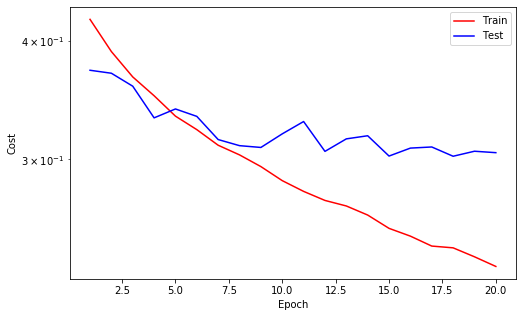

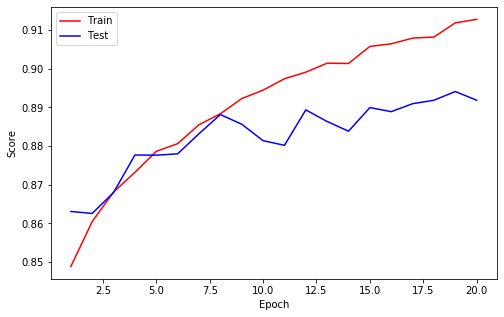

Train:   1%|▍                                            | 3/313 [00:00<00:12, 25.00it/s]

==> EarlyStop patience =  1 | Best test_score: 0.8941


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.53it/s]


Epoch    21
Train_cost  = 0.2261 | Test_cost  = 0.3159 | Train_score = 0.9161 | Test_score = 0.8930 |
==> EarlyStop patience =  2 | Best test_score: 0.8941


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.77it/s]


Epoch    22
Train_cost  = 0.2258 | Test_cost  = 0.3034 | Train_score = 0.9134 | Test_score = 0.8937 |
==> EarlyStop patience =  3 | Best test_score: 0.8941


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.03it/s]


Epoch    23
Train_cost  = 0.2190 | Test_cost  = 0.3019 | Train_score = 0.9178 | Test_score = 0.8944 |


Train:   1%|▍                                            | 3/313 [00:00<00:10, 28.29it/s]


Epoch    24
Train_cost  = 0.2142 | Test_cost  = 0.3127 | Train_score = 0.9202 | Test_score = 0.8910 |
==> EarlyStop patience =  1 | Best test_score: 0.8944


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.51it/s]


Epoch    25
Train_cost  = 0.2145 | Test_cost  = 0.3146 | Train_score = 0.9177 | Test_score = 0.8925 |
==> EarlyStop patience =  2 | Best test_score: 0.8944


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.78it/s]


Epoch    26
Train_cost  = 0.2057 | Test_cost  = 0.3175 | Train_score = 0.9228 | Test_score = 0.8900 |
==> EarlyStop patience =  3 | Best test_score: 0.8944


Train:   1%|▍                                            | 3/313 [00:00<00:11, 27.78it/s]


Epoch    27
Train_cost  = 0.2050 | Test_cost  = 0.3138 | Train_score = 0.9211 | Test_score = 0.8932 |
==> EarlyStop patience =  4 | Best test_score: 0.8944


Test: 100%|████████████████████████████████████████████| 157/157 [00:07<00:00, 21.35it/s]



Epoch    28
Train_cost  = 0.1978 | Test_cost  = 0.3153 | Train_score = 0.9254 | Test_score = 0.8934 |
==> EarlyStop patience =  5 | Best test_score: 0.8944
==> Execute Early Stopping at epoch: 28 | Best test_score: 0.8944
==> Best model is saved at model


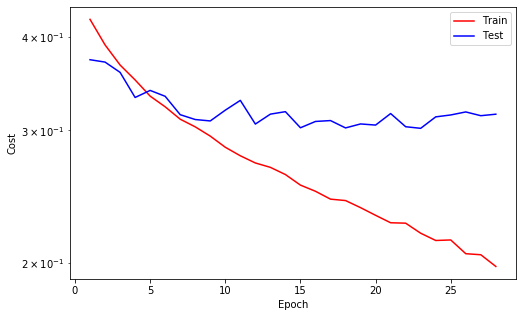

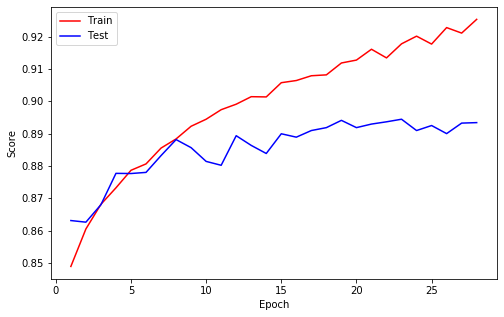

In [34]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [35]:
!nvidia-smi

Wed Oct 07 20:46:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 425.46       Driver Version: 425.46       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   67C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [36]:
torch.cuda.current_device()

0

In [38]:
torch.cuda.device(0)

In [39]:
torch.cuda.device_count()

1

In [40]:
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

In [41]:
torch.cuda.is_available()

True

# Load best model

In [49]:
# Kalau mau nge run di notebook lain

weights = torch.load("model/weights_best.pth", map_location="cuda")
config = torch.load("model/configs.pth", map_location="cuda")

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
model.load_state_dict(weights)
model = model.to(device)

In [50]:
model.state_dict()

OrderedDict([('fc.1.block.linear.weight',
              tensor([[ 0.3399,  0.2197, -0.0570,  ..., -0.0679, -0.2506, -0.1260],
                      [ 0.1978,  0.1906, -0.0034,  ..., -0.3085, -0.0183,  0.0688],
                      [-0.0310, -0.0166,  0.0010,  ..., -0.2334, -0.1119, -0.1374],
                      ...,
                      [ 0.1616,  0.1459, -0.0548,  ...,  0.1562,  0.2279,  0.2682],
                      [ 0.1993,  0.1005, -0.2797,  ..., -0.0424, -0.0449, -0.2152],
                      [ 0.0018,  0.0102, -0.0165,  ..., -0.0353,  0.0016,  0.0129]],
                     device='cuda:0')),
             ('fc.1.block.linear.bias',
              tensor([ 1.5971e-01,  1.2317e-01,  5.5964e-01,  5.8085e-02, -6.1814e-03,
                       5.4214e-01,  1.9761e-01,  4.2718e-02,  2.9911e-01,  1.2682e-01,
                       1.2612e-01,  1.2478e-01,  2.3938e-01, -3.4676e-02,  2.3792e-01,
                      -4.9712e-03, -1.2771e-01, -3.6262e-01,  3.1962e-01, -2.2836e-02

# Prediksi

In [51]:
feature, target = next(iter(testloader)) # Karena contoh, harus nya testloader nya pakai data test yg berbeda
feature, target = feature.to(device), target.to(device)

In [52]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Sneaker',
 'Ankle boot',
 'Sneaker',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Sneaker',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'Ankle boot',
 'An

# Visualisasi 

In [53]:
import matplotlib.pyplot as plt

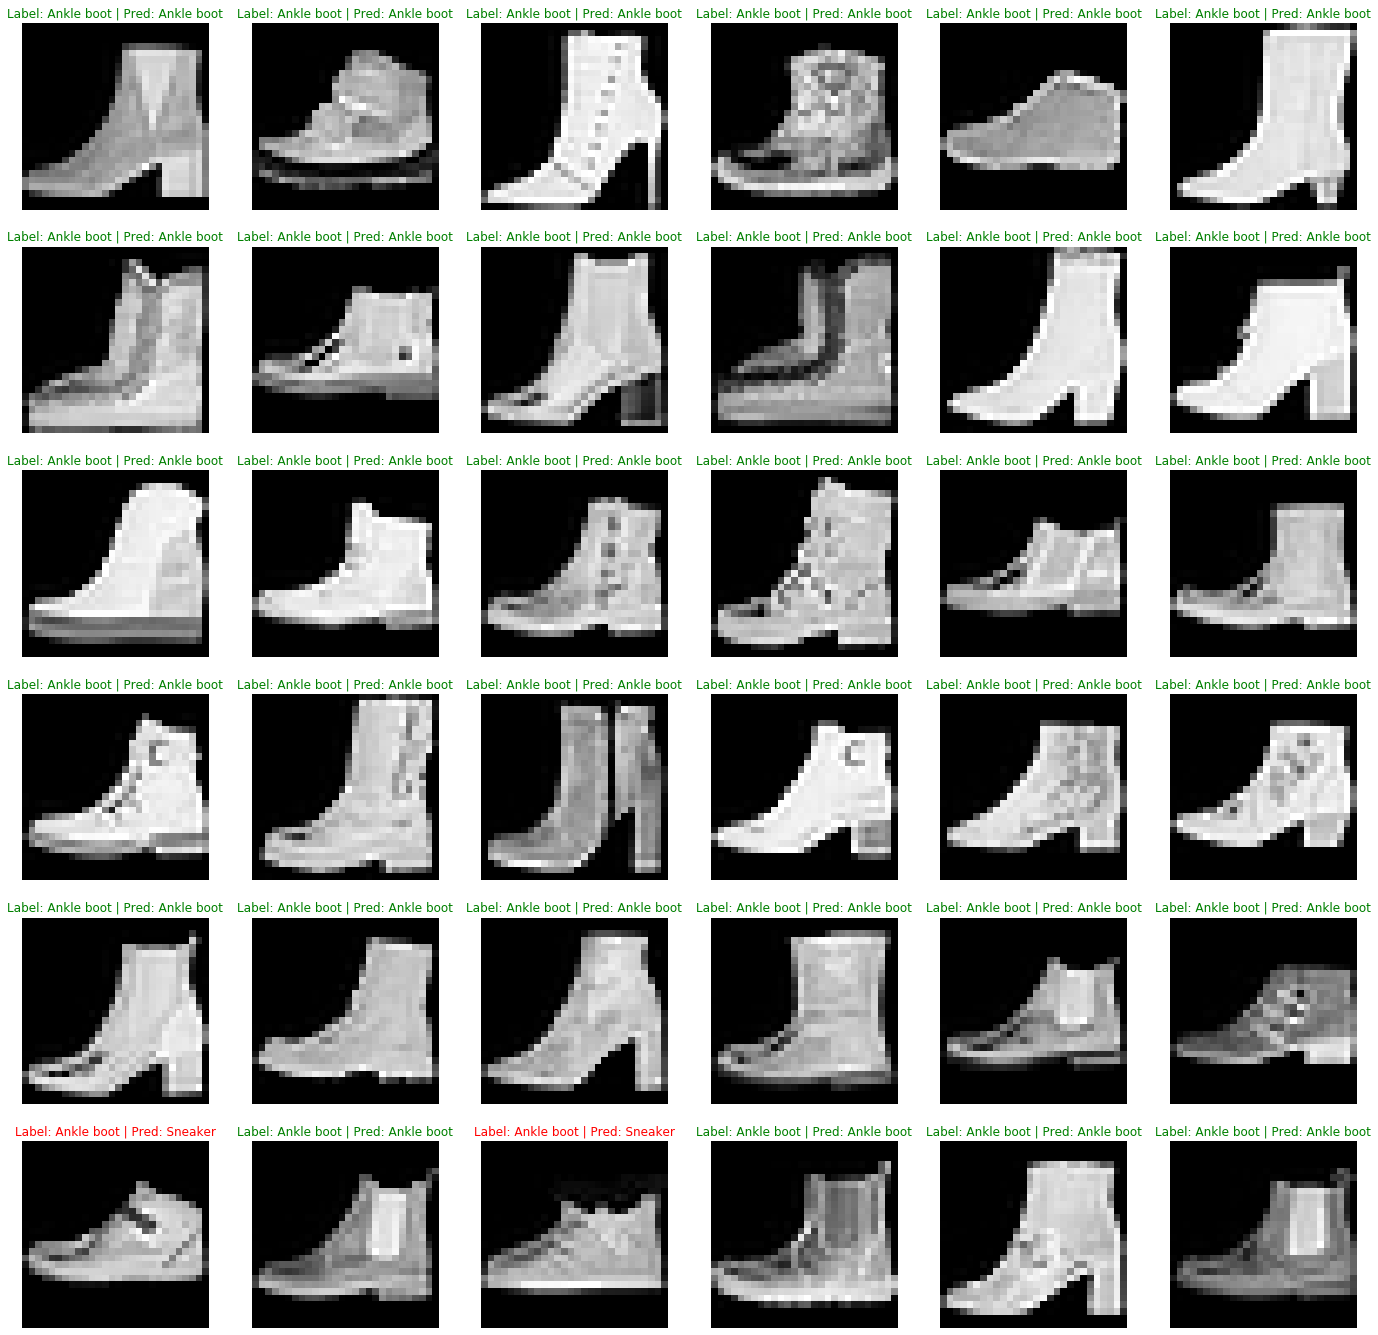

In [55]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');